In [80]:
import numpy as np
from PIL import Image
from matplotlib.path import Path
import matplotlib.pyplot as plt
import time
import os
import glob
import pandas as pd
import pickle
from scipy.ndimage import label 

# Start timing the process
start_time = time.time()

og_path = '/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate1'

# Get all Laso for each wells
paths_ = glob.glob(og_path +'_final/Laso/*.pkl')
paths_.sort(key=os.path.getmtime, reverse=False)

names_ = [os.path.basename(x)[4:-4]+'.tif' for x in paths_]

#List
name_keep = []
cell_count_keep = []
colonyID_keep = []
colony_area_keep =[]

paths_ =['/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate1_final/Laso/LasoVID826_H7_1_20d00h00m.pkl','/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate1_final/Laso/LasoVID826_E9_1_20d00h00m.pkl']
names_ = [os.path.basename(x)[4:-4]+'.tif' for x in paths_]
# Load the polygon vertices and create a Path object
# paths_ = paths_[0:2]
for l,pL in enumerate(paths_):
    print(pL)
    
    #os.makedirs(og_path+ '_final/final_data/'+pL.split('_')[-3])
    # Use pickle to load
    with open(pL, 'rb') as f:
        loaded_larrays = pickle.load(f)
        
    for j in range(0,len(loaded_larrays)):

    
        polygon_vertices = loaded_larrays[j]
        polygon_path = Path(polygon_vertices)

        paths_mask = sorted(glob.glob(og_path +'/' + names_[l][:-14] + '*.tif' ),reverse = True)

        for i,pm in enumerate(paths_mask):
#             print(pm)
            # Open the mask image using memory mapping to avoid reading the entire file into memory
            mask = Image.open(pm)

            #Allign images and mask
            mask = mask.transpose(Image.TRANSPOSE)      
            
             # Convert the image to grayscale and threshold
            gray_img = mask.convert('L')
            np_img = np.array(gray_img)
            binary_mask = (np_img > 0).astype(np.uint8)

            # Label the objects in the binary mask
            labeled_mask = label(binary_mask)
            
            # Generate a boolean mask of points inside the polygon
            x, y = np.meshgrid(np.arange(binary_mask.shape[1]), np.arange(binary_mask.shape[0]))
            points = np.vstack((x.ravel(), y.ravel())).T
            inside_polygon = polygon_path.contains_points(points)
            mask_inside_polygon = binary_mask & inside_polygon.reshape(binary_mask.shape)
            
            # Use the label function to label all connected regions (cells) in the binary mask
            labeled_mask, num_features = label(mask_inside_polygon)

            # Use np.where to get the indices where mask_inside_polygon is True
            inside_indices = np.where(mask_inside_polygon)

            # Get the labels from labeled_mask at these indices
            intersecting_labels = labeled_mask[inside_indices]

            # Now intersecting_labels contains all labels for cells that intersect with our polygon
            # Count unique labels to find the number of cells in the polygon
            unique_labels = np.unique(intersecting_labels)

            # Exclude the background label (which is typically 0) if it's included
            unique_labels = unique_labels[unique_labels != 0]

            # The number of unique labels corresponds to the number of cells
            number_of_cells = len(unique_labels)
            
            cell_count_keep.append(number_of_cells )
            
            # Find the positions of the cell pixels
            cell_pixel_positions = np.column_stack(np.where(mask_inside_polygon))

            # Calculate the convex hull around the cell pixels if there are enough points
            if cell_pixel_positions.shape[0] > 2:  # ConvexHull needs at least 3 points to work
                hull = ConvexHull(cell_pixel_positions)
                colony_area = hull.volume  # In 2D, 'volume' attribute gives the area
            else:
                colony_area = 0  # This handles the case with too few points for a convex hull
            
            # Store the colony area
            colony_area_keep.append(colony_area)
            
            #store values
            name_keep.append(pm.split('/')[-1][:-4])
            colonyID_keep.append(j)
            
            

            # Visualize the result
            plt.imshow(binary_mask, cmap='gray')
            plt.imshow(mask_inside_polygon, cmap='jet', alpha=0.5)
            # Save the figure
            plt.savefig(og_path+ '_final/final_data/'+pL.split('_')[-3]+'/'+ pm.split('/')[-1][:-4]+str(j)+'.png', bbox_inches='tight')
            
            # If you no longer need the plot in memory, you can close it with plt.close()
            plt.close()


well_ID = []
for i,n in enumerate(name_keep):
    well_ID.append(n[7:10]+'_'+str(colonyID_keep[i]))
    
# Combine these lists into a dictionary
data = {
    'ColonySize': cell_count_keep,
    'Colony_Area': colony_area_keep,
    'Name': name_keep,
    'Well': [n[7:10] for n in name_keep],
    'Time': [n[-9:] for n in name_keep],
    'ColonyID': colonyID_keep,
    'well_ID':well_ID
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(og_path + '_final/final_data/'+pL.split('/')[-1][4:-20] + '.csv', index=False)  # Set index=False if you don't want to save the index


/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate1_final/Laso/LasoVID826_H7_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate1_final/Laso/LasoVID826_E9_1_20d00h00m.pkl


In [200]:
# analyze data

In [712]:
# Save the DataFrame to a CSV file
df1 = pd.read_csv('/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate1_final/final_data/VID826.csv')  # Set index=False if you don't want to save the index


In [713]:
# Save the DataFrame to a CSV file
df2 = pd.read_csv('/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/final_data/VID827.csv')  # Set index=False if you don't want to save the index


In [982]:
frames = [df1, df2]

df = pd.concat(frames)

In [983]:
plate_ID = []
for i,n in zip(df.well_ID,df.Name):
    plate_ID.append(i  + '_'+n[:6])

In [984]:
df['well_ID'] = plate_ID

In [985]:
df

,ColonySize,Colony_Area,Name,Well,Time,ColonyID,well_ID,TimeMinutes
0,22,22761.5,VID826_H9_1_24d00h00m,H9_,24d00h00m,0,H9__0_VID826_VID826_VID826,24.0
1,19,22803.0,VID826_H9_1_23d00h00m,H9_,23d00h00m,0,H9__0_VID826_VID826_VID826,23.0
2,18,22392.0,VID826_H9_1_22d00h00m,H9_,22d00h00m,0,H9__0_VID826_VID826_VID826,22.0
3,17,22276.5,VID826_H9_1_21d00h00m,H9_,21d00h00m,0,H9__0_VID826_VID826_VID826,21.0
4,20,22706.5,VID826_H9_1_20d00h00m,H9_,20d00h00m,0,H9__0_VID826_VID826_VID826,20.0
...,...,...,...,...,...,...,...,...
2745,8,4336.5,VID827_A11_1_04d00h00m,A11,04d00h00m,0,A11_0_VID827,NaN
2746,6,1985.5,VID827_A11_1_03d00h00m,A11,03d00h00m,0,A11_0_VID827,NaN
2747,6,1147.0,VID827_A11_1_02d00h00m,A11,02d00h00m,0,A11_0_VID827,NaN
2748,4,436.5,VID827_A11_1_01d00h00m,A11,01d00h00m,0,A11_0_VID827,NaN


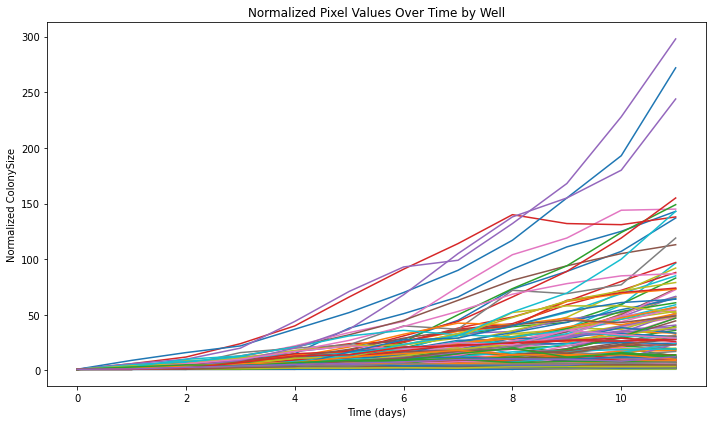

<Figure size 432x288 with 0 Axes>

In [986]:
import re

# df = pd.DataFrame(data)
# df = pd.DataFrame(data)

# L = ['C11_0','F9__2','F9__1','H8__1','H7__0']
# for l in L:
#     df = df[df['well_ID'] != l]

# Function to convert time string to total minutes
def convert_time_to_minutes(timestr):
    parts = re.match(r"(\d+)d(\d+)h(\d+)m", timestr)
    days, hours, minutes = map(int, parts.groups())
    return (days * 60*24 + hours * 60 + minutes)/1440 

# Convert 'Time' to total minutes
df['TimeMinutes'] = df['Time'].apply(convert_time_to_minutes)

df = df.sort_values(by=['Name', 'ColonyID', 'TimeMinutes'])

# Normalize Pixels to the first value for each Well
# df['NormalizedPixels'] = df.groupby('Well')['Pixels'].transform(lambda x: x / x.iloc[0])

# Normalize the pixel values to the first timepoint for each 'Name'/'ColonyID'
df['NormalizedColonySize'] = df.groupby('well_ID')['ColonySize'].transform(lambda x: x / x.iloc[0] if x.iloc[0] != 0 else 0)

# df['NormalizedColonySize'][df['NormalizedColonySize'] < 1] = 1

# Identify colonies with any point having less than one cell
colonies_to_remove = df[df['NormalizedColonySize'] < 1]['well_ID'].unique()



# Filter out these colonies from the DataFrame
df = df[~df['well_ID'].isin(colonies_to_remove)]

colonies_to_remove = df[np.isnan(df['NormalizedColonySize'])]['well_ID'].unique()

# Filter out these colonies from the DataFrame
df = df[~df['well_ID'].isin(colonies_to_remove)]

time_grown = 12
df = df[df['TimeMinutes']<time_grown]

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size as desired

# Group by 'Well' and plot
for label, group in df.groupby('well_ID'):
    
    plt.plot(group['TimeMinutes'], group['NormalizedColonySize'], label=label)

    
# Group by 'Well' and plot
# for label, group in df.groupby('well_ID'):
#     plt.scatter(group['TimeMinutes'], np.log2(group['NormalizedColonySize']), c='black', label=label)

plt.xlabel('Time (days)')
plt.ylabel('Normalized ColonySize')
plt.title('Normalized Pixel Values Over Time by Well')
# plt.legend()
plt.tight_layout()
plt.show()

plt.savefig('/Users/raul/Desktop/96well_mask/mCherry_plate1_.pdf')


In [987]:
# Group by 'well_ID', then take the last entry for each group
df_final_timepoint = df[df['TimeMinutes']<time_grown].groupby('well_ID').apply(lambda x: x.iloc[-1])

# Sort the well_IDs by the 'Pixels' column in descending order
top_wells = df_final_timepoint.sort_values('ColonySize', ascending=False).head(6)

# Display the top 5 well_IDs with the largest 'Pixels' values at the final timepoint
print("Top 5 well_IDs with the most pixels at the final time point:")
print(top_wells[['NormalizedColonySize']])

Top 5 well_IDs with the most pixels at the final time point:
                            NormalizedColonySize
well_ID                                         
A8__0_VID827                           39.923077
B2__0_VID827                           83.000000
A6__0_VID827                           96.400000
D10_0_VID826_VID826_VID826             92.000000
E9__0_VID826_VID826_VID826             64.428571
F8__0_VID827                           49.750000


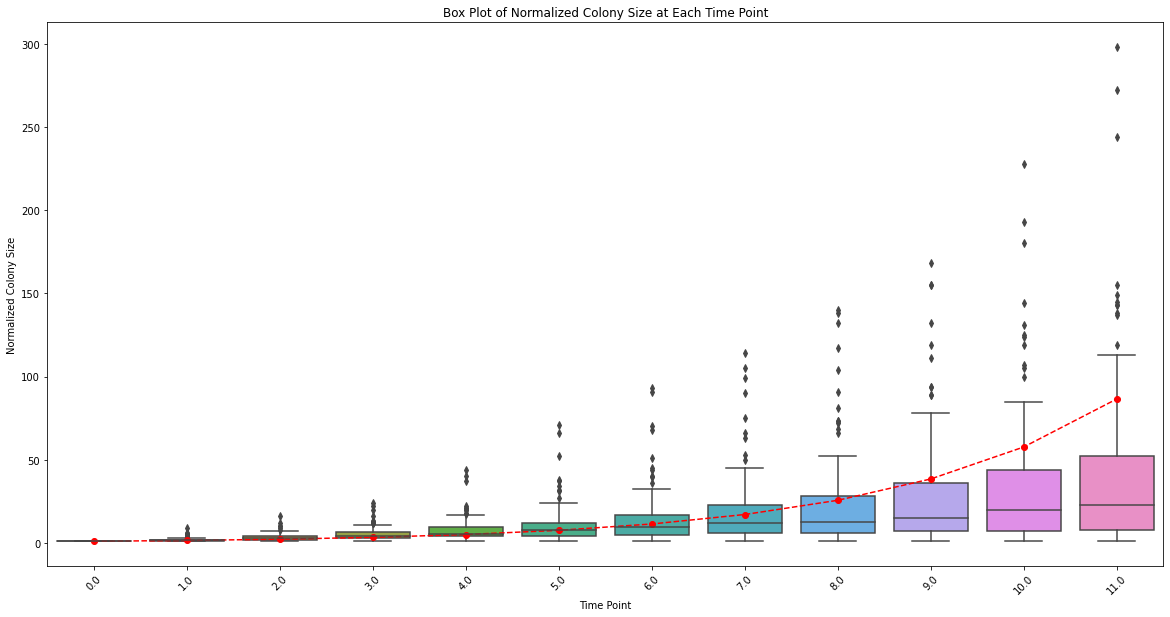

In [988]:
import seaborn as sns
# Set the figure size for readability
plt.figure(figsize=(20, 10))

# Create a boxplot
# Here 'Time' is the column containing the time points,
# 'NormalizedColonySize' is the data to plot,
# and 'Well' is the grouping variable (if you have one)
sns.boxplot(x='TimeMinutes', y='NormalizedColonySize', data=df)

time_points = df['TimeMinutes'].sort_values().unique()
exponential_growth = 1.5**time_points

# Plot the exponential points on top of the boxplot
plt.plot(time_points, exponential_growth, 'ro')  # 'ro' is for red colored dots

# Optional: connect the dots with a line to indicate the trend
plt.plot(time_points, exponential_growth, 'r--')  # 'r--' is for a red dashed line

# Set plot title and labels
plt.title('Box Plot of Normalized Colony Size at Each Time Point')
plt.xlabel('Time Point')
plt.ylabel('Normalized Colony Size')

# Show the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()

In [989]:
# Fit model

In [990]:
# Add expanding and committed ID
df['ProliferationID'] = [0]*len(df["TimeMinutes"])
for day in np.unique(df["TimeMinutes"]):
    logic_d = df['NormalizedColonySize'] > df[df["TimeMinutes"] == day].quantile(.90)['NormalizedColonySize']
    logic_d[df["TimeMinutes"] != day] = False
    
    HOLD = df['ProliferationID']
    
    HOLD[logic_d] = 1

    df['ProliferationID'] = HOLD

<ipython-input-990-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOLD[logic_d] = 1
<ipython-input-990-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOLD[logic_d] = 1
<ipython-input-990-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOLD[logic_d] = 1
<ipython-input-990-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

Best-fit parameters:
k1: 0.9098702046681928
Growth rate: 1.090541152234427


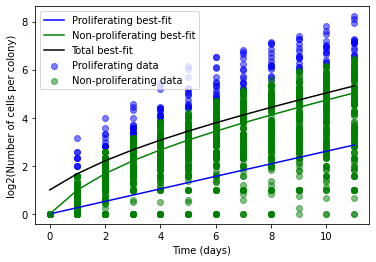

In [991]:
df = df.sort_values(by=["TimeMinutes"])

from scipy.optimize import minimize
from scipy.integrate import odeint
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import minimize


prolif_data = [ i for i in df['NormalizedColonySize'][df['ProliferationID']==1] ] 

non_prolif_data = [ i for i in df['NormalizedColonySize'][df['ProliferationID']==0] ] 

synthetic_data_combined = np.array(df['NormalizedColonySize'])
t_synthetic_repeated = np.array(df["TimeMinutes"])

# Initial conditions
y0 = [1, 1]  # Initial number of proliferating and non-proliferating cells

# Time vector
t = np.linspace(0, 10, 100)  # Time points from 0 to 100 with 100 points


# Define the ODE model
def two_state_system(y, t, k1, growth_rate):
    proliferating, non_proliferating = y
    
    dydt = [
        growth_rate * proliferating - k1 * proliferating ,  # Change in proliferating cells
        k1 * proliferating   # Change in non-proliferating cells
    ]
    return dydt


def cost_function_combined(params, t, combined_data):
    k1, growth_rate = params
    solution = odeint(two_state_system, y0, t, args=(k1, growth_rate))

    # Combine the model's populations into a single population
    combined_solution = np.sum(solution, axis=1)

    # Calculate the sum of squared differences
    ssd = np.sum((combined_solution - combined_data) ** 2)
    return ssd

# Initial conditions
y0 = [1, 1]  # Initial number of proliferating and non-proliferating cells

# Initial parameter values
initial_params = [0.2, 0.7]  # Initial values for k1, and growth_rate


# Optimize the parameters
result = minimize(cost_function_combined, initial_params, args=(t_synthetic_repeated, synthetic_data_combined), method='L-BFGS-B', bounds=[(0, None), (0, None)])

# Extract the best-fit parameters
k1_best, growth_rate_best = result.x


# Generate the best-fit solution
solution_best_fit = odeint(two_state_system, y0, t_synthetic_repeated, args=(k1_best, growth_rate_best))

# # Evaluate the goodness of fit using the R-squared value
# ssd_best_fit = np.sum((solution_best_fit - experimental_data) ** 2)
# sst = np.sum((experimental_data - np.mean(experimental_data, axis=0)) ** 2)
# r_squared = 1 - (ssd_best_fit / sst)

print("Best-fit parameters:")
print("k1:", k1_best)
print("Growth rate:", growth_rate_best)
#print("R-squared:", r_squared)

# Get the time points corresponding to proliferating and non-proliferating data
prolif_time_points = df['TimeMinutes'][df['ProliferationID']==1] 
non_prolif_time_points = df['TimeMinutes'][df['ProliferationID']==0] 


path_to_save = '/Users/raul/Desktop/96well_mask/mCherry_sup1.pdf'

with PdfPages(path_to_save) as pdf:
    # Set up the figure and axis
    fig, ax = plt.subplots()
    # Plot the experimental data
    ax.scatter(prolif_time_points, np.log2(prolif_data), label='Proliferating data', c='b', marker='o', alpha=0.5)
    ax.scatter(non_prolif_time_points, np.log2(non_prolif_data), label='Non-proliferating data', c='g', marker='o', alpha=0.5)

    # Plot the best-fit model
    ax.plot(t_synthetic_repeated, np.log2(solution_best_fit[:, 0]), label='Proliferating best-fit', c='b', linestyle='-')
    ax.plot(t_synthetic_repeated, np.log2(solution_best_fit[:, 1]), label='Non-proliferating best-fit', c='g', linestyle='-')
    ax.plot(t_synthetic_repeated, np.log2(solution_best_fit[:, 0]+solution_best_fit[:, 1]), label='Total best-fit', c='k', linestyle='-')


    plt.xlabel('Time (days)')
    plt.ylabel('log2(Number of cells per colony)')
    plt.legend()
    plt.show()


    pdf.savefig(fig)



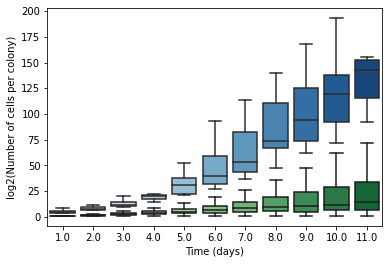

In [1012]:
path_to_save = '/Users/raul/Desktop/96well_mask/mCherry_sup.pdf'

with PdfPages(path_to_save) as pdf:
    # Set up the figure and axis
    fig, ax = plt.subplots()
    # Plot the experimental data
    axis_y = 'NormalizedColonySize' 
    
    ax = sns.boxplot(x="TimeMinutes", y =  axis_y, data=df_halt, palette="Greens",showfliers=False)
    ax = sns.boxplot(x="TimeMinutes", y =  axis_y, data=df_expanding, palette="Blues",showfliers=False)


    plt.xlabel('Time (days)')
    plt.ylabel('log2(Number of cells per colony)')
    plt.show()


    pdf.savefig(fig)

In [992]:
synthetic_data_combined = np.array(df['NormalizedColonySize'])
t_synthetic_repeated = np.array(df["TimeMinutes"])


synthetic_data_combined = np.array([ i for i in df['NormalizedColonySize'][df['ProliferationID']==1] ]) 
t_synthetic_repeated= np.array([ i for i in df['TimeMinutes'][df['ProliferationID']==1] ] )

In [993]:


from scipy.optimize import curve_fit
# Function to calculate the power-law with constants a and b

# f = a * x^b    => $$P_t = P_o * \lambda^t $$

def power_law(x, a, b):
    return a*np.power(b, x)

[5.333333333333333, 9.090909090909092, 13.833333333333334, 22.766666666666666, 34.8, 48.36666666666667, 63.9, 87.23333333333333, 103.2, 124.66666666666667, 156.09333333333333]
Fit parameters and standard deviations:

    Po = 10.273 - 1.435
lambda = 1.285 - 0.019


Division rate:

    ln(mean(data_lambda)) = 0.498
ln(mean(expo_lambda_exp)) = 1.000

STD
ln(mean(std_data_lambda)) = -2.538


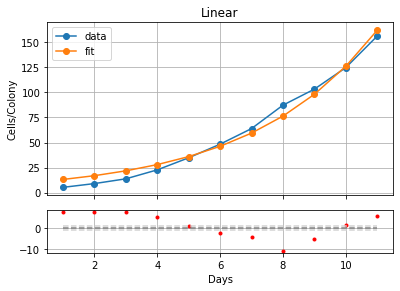

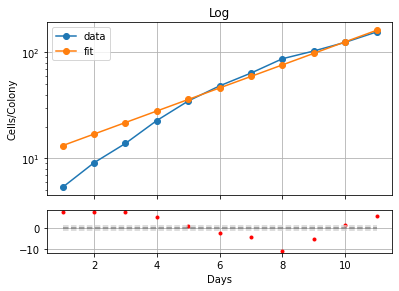

In [994]:

df_expanding = df[df['ProliferationID']==1]

# Data to fit
days = np.unique(df_expanding["TimeMinutes"])
day_col_mean    = [np.mean(df_expanding['NormalizedColonySize'][df_expanding['TimeMinutes'] == i]) for i in np.unique(df_expanding['TimeMinutes'])]


print(day_col_mean )
# Fit data
pars, cov = curve_fit(f=power_law, xdata=days, ydata=day_col_mean, p0=[1, 1.5], bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))


# Calculate the residuals
res = day_col_mean - power_law(days, *pars)

print("Fit parameters and standard deviations:")
print("")
print('    Po = {:0.3f} - {:0.3f}'.format(pars[0], stdevs[0]))
print('lambda = {:0.3f} - {:0.3f}'.format(pars[1], stdevs[1]))
print("")

#Division rates
div_rate = [day_col_mean[i]/day_col_mean[i-1] for i in range(1,len(day_col_mean))]


exp_mod = 2**days
div_rate_exp = [exp_mod[i]/exp_mod[i-1] for i in range(1,len(exp_mod))]

print("")
print("Division rate:")
print("")
print('    ln(mean(data_lambda)) = {:0.3f}' .format(np.log2(np.mean(div_rate))))

print('ln(mean(expo_lambda_exp)) = {:0.3f}' .format(np.log2(np.mean(div_rate_exp))))
print("")
print("STD")
print('ln(mean(std_data_lambda)) = {:0.3f}'.format(np.log2(np.std(div_rate))))


#PLOT
fig1 = plt.figure(1)

#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.plot(days,day_col_mean,'-o')
plt.plot(days,power_law(days, *pars),'-o')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel('Cells/Colony')
plt.title("Linear")
plt.legend(["data","fit"])
plt.grid()

#Residual plot
difference = power_law(days, *pars) - day_col_mean
frame2=fig1.add_axes((.1,.1,.8,.15))        
plt.plot(days,difference,'.r')
plt.plot(days,days*0,'--',color = "gray")
plt.plot(days,days*0 + len(days)*[1],'--',color = "lightgray")
plt.plot(days,days*0 + len(days)*[-1],'--',color = "lightgray")
plt.xlabel('Days')
plt.grid()
# plt.ylim(-2.5,2.5)
plt.savefig('/Users/raul/Desktop/96well_mask/mCherry_sup2.pdf')

fig2 = plt.figure(2)
#Log
frame1=fig2.add_axes((.1,.3,.8,.6))
plt.plot(days,day_col_mean,'-o')
plt.plot(days,power_law(days, *pars),'-o')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.yscale("log")
plt.ylabel('Cells/Colony')
plt.legend(["data","fit"])
plt.title("Log")
plt.grid()

#Residual plot
difference = power_law(days, *pars) - day_col_mean
frame2=fig2.add_axes((.1,.1,.8,.15))        
plt.plot(days,difference,'.r')
plt.plot(days,days*0,'--',color = "gray")
plt.plot(days,days*0 + len(days)*[1],'--',color = "lightgray")
plt.plot(days,days*0 + len(days)*[-1],'--',color = "lightgray")
plt.xlabel('Days')
# plt.ylim(-2.5,2.5)
plt.grid()

# path_to_save = cwd + 'Paper/outputs/figures/supplement_figure1/supplement_figure1_H1.pdf'
plt.savefig('/Users/raul/Desktop/96well_mask/mCherry_sup3.pdf')

In [995]:
t_exp_1, S_exp_1  = days, day_col_mean
t_mod_1, S_mod_1 = days, power_law(days, *pars)



In [996]:
# Time dependant 

In [997]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

expanding [ 1.          1.67925083  2.92201561  4.2840441   5.85604184  7.57317977
  9.94781347 12.90604114 14.94607988 18.33487743 22.15250423 25.89188081]
0.19788418340376634 6.318778428349809 0.9


/Users/raul/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/raul/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


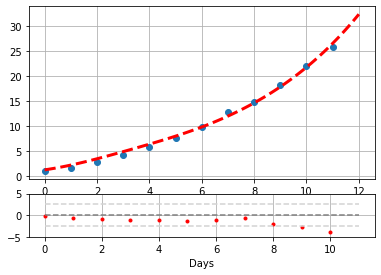

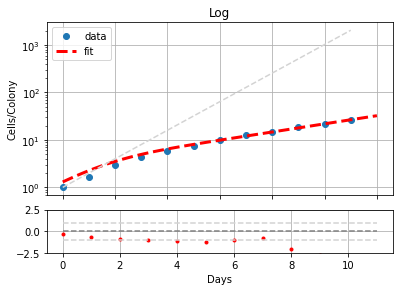

In [998]:
df_halt = df[df['ProliferationID']==0]
days = np.array(range(0,len(np.unique(df_halt.TimeMinutes))))
#"""Experimental data!"""
t_exp = np.unique(np.array(df_halt.TimeMinutes) )

S_exp =[]
S_std =[]
for t in t_exp:
    S_exp.append(np.mean(df_halt.NormalizedColonySize[df_halt.TimeMinutes == t]))
    S_std.append(np.mean(df_halt.NormalizedColonySize[df_halt.TimeMinutes == t]))


print("expanding",np.unique(S_exp))

# SETTING UP THE MODEL
 
def f(t, c1,c2,g):
    
    #'Function that returns mutually dependent variables C' and H'
    def growth(x, t):

        C = x[0]
        H = x[1]
        

        gc = (c2 - C+H)/c2
        k1 = c1 
        
        

        dCdt = gc*C - k1*C 
        dHdt = k1*C
        
        return  [dCdt,dHdt]
    
    # INTEGRATING THE DIFFERENTIAL EQUATIONS
    #"initial Conditions"
    init = [1.3,0]
    results = odeint(growth, init, t)
    #"Taking out desired column vectors from results array"
    return results[:,0]

# CURVE FITTING AND PARAMETER ESTIMATION
c1 = .5
c2 = 50
g = .9

k, kcov = curve_fit(f, t_exp, S_exp, p0=( c1,c2,g))

c1 = k[0]
c2 = k[1]
g = k[2]
print(c1,c2,g)


# RESULTS OF THE MODEL WITH THE ESTIMATED MODEL PARAMETERS
t_mod = np.linspace(0, len(np.unique(df_halt.TimeMinutes)), 120)


compute = f(t_mod, c1,c2,g)
# compute = compute.reshape((2,-1))

S_mod = compute



# PLOT OF THE MODEL AND THE OBSERVED DATA
fig = plt.figure(1)
frame1=fig.add_axes((.1,.3,.8,.6))
plt.plot(t_exp, S_exp, "o", )
plt.plot(t_mod, S_mod, "r--", linewidth=3)
#plt.set_ylabel("Halt", color="r")
plt.grid()

t_mod_r = np.linspace(0, len(np.unique(df_halt.TimeMinutes)), len(np.unique(df_halt.TimeMinutes)))


compute = f(t_mod_r, c1,c2,g)
S_mod_r = compute

#Residual plot
difference = S_exp - S_mod_r
frame2=fig.add_axes((.1,.1,.8,.15))              
plt.plot(days,difference,'.r')
plt.plot(days,days*0,'--',color = "gray")
plt.plot(days,days*0 + len(days)*[2.5],'--',color = "lightgray")
plt.plot(days,days*0 + len(days)*[-2.5],'--',color = "lightgray")
plt.xlabel('Days')
plt.ylim(-5,5)
plt.grid()



#plt.savefig(path_to_plot + "halt_fit_time_growth_rate.pdf")
path_to_save = '/Users/raul/Desktop/96well_mask/mCherry_sup4.pdf'
plt.savefig(path_to_save)



fig2 = plt.figure(2)
#Log
frame1=fig2.add_axes((.1,.3,.8,.6))
plt.plot(t_exp, S_exp, "o", )
plt.plot(t_mod, S_mod, "r--", linewidth=3)
plt.plot(days,2**days ,'--',color = "lightgray")

#ax2.set_ylabel("Halt", color="r")
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.yscale("log")#, basey=2)
plt.ylabel('Cells/Colony')
plt.legend(["data","fit"])
plt.title("Log")
plt.grid()

#Residual plot
difference = S_exp - S_mod_r
frame2=fig2.add_axes((.1,.1,.8,.15))        
plt.plot(days,difference,'.r')
plt.plot(days,days*0,'--',color = "gray")
plt.plot(days,days*0 + len(days)*[1],'--',color = "lightgray")
plt.plot(days,days*0 + len(days)*[-1],'--',color = "lightgray")
plt.xlabel('Days')
plt.ylim(-2.5,2.5)
plt.grid()



In [999]:
t_mod_0, S_mod_0 = t_mod[1:], S_mod[1:]
t_exp_0, S_exp_0  = t_exp[1:], S_exp[1:]

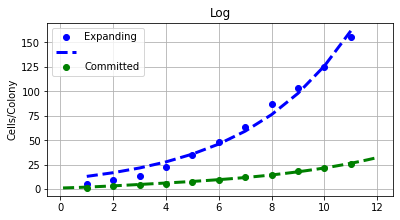

In [1000]:




fig2 = plt.figure(5)
#Log
frame1=fig2.add_axes((.1,.3,.8,.6))
plt.plot(t_exp_1, S_exp_1, "bo", )
plt.plot(t_mod_1, S_mod_1, "b--", linewidth=3)
plt.plot(t_exp_0, S_exp_0, "go", )
plt.plot(t_mod_0, S_mod_0, "g--", linewidth=3)
# plt.plot(days,2**days ,'--',color = "lightgray")

#ax2.set_ylabel("Halt", color="r")
# frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
# plt.yscale("log", basey=2)
plt.ylabel('Cells/Colony')
plt.legend(["Expanding","","Committed"])
plt.title("Log")
plt.grid()



path_to_save = '/Users/raul/Desktop/96well_mask/mCherry_sup5.pdf'
plt.savefig(path_to_save)

In [137]:
import numpy as np
from PIL import Image
from matplotlib.path import Path
import matplotlib.pyplot as plt
import time
import os
import glob
import pandas as pd
import pickle
from scipy.ndimage import label 

# Start timing the process
start_time = time.time()

og_path = '/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2'

# Get all Laso for each wells
paths_ = glob.glob(og_path +'_final/Laso/*.pkl')
paths_.sort(key=os.path.getmtime, reverse=False)

names_ = [os.path.basename(x)[4:-4]+'.tif' for x in paths_]

#List
name_keep = []
cell_count_keep = []
colonyID_keep = []
colony_area_keep =[]


# Load the polygon vertices and create a Path object
# paths_ = paths_[0:2]
for l,pL in enumerate(paths_):
    print(pL)
    
    os.makedirs(og_path+ '_final/final_data/'+pL.split('_')[-3])
    # Use pickle to load
    with open(pL, 'rb') as f:
        loaded_larrays = pickle.load(f)
        
    for j in range(0,len(loaded_larrays)):

    
        polygon_vertices = loaded_larrays[j]
        polygon_path = Path(polygon_vertices)

        paths_mask = sorted(glob.glob(og_path +'/' + names_[l][:-14] + '*.tif' ),reverse = True)

        for i,pm in enumerate(paths_mask):
#             print(pm)
            # Open the mask image using memory mapping to avoid reading the entire file into memory
            mask = Image.open(pm)

            #Allign images and mask
            mask = mask.transpose(Image.TRANSPOSE)      
            
             # Convert the image to grayscale and threshold
            gray_img = mask.convert('L')
            np_img = np.array(gray_img)
            binary_mask = (np_img > 0).astype(np.uint8)

            # Label the objects in the binary mask
            labeled_mask = label(binary_mask)
            
            # Generate a boolean mask of points inside the polygon
            x, y = np.meshgrid(np.arange(binary_mask.shape[1]), np.arange(binary_mask.shape[0]))
            points = np.vstack((x.ravel(), y.ravel())).T
            inside_polygon = polygon_path.contains_points(points)
            mask_inside_polygon = binary_mask & inside_polygon.reshape(binary_mask.shape)
            
            # Use the label function to label all connected regions (cells) in the binary mask
            labeled_mask, num_features = label(mask_inside_polygon)

            # Use np.where to get the indices where mask_inside_polygon is True
            inside_indices = np.where(mask_inside_polygon)

            # Get the labels from labeled_mask at these indices
            intersecting_labels = labeled_mask[inside_indices]

            # Now intersecting_labels contains all labels for cells that intersect with our polygon
            # Count unique labels to find the number of cells in the polygon
            unique_labels = np.unique(intersecting_labels)

            # Exclude the background label (which is typically 0) if it's included
            unique_labels = unique_labels[unique_labels != 0]

            # The number of unique labels corresponds to the number of cells
            number_of_cells = len(unique_labels)
            
            cell_count_keep.append(number_of_cells )
            
            # Find the positions of the cell pixels
            cell_pixel_positions = np.column_stack(np.where(mask_inside_polygon))

            # Calculate the convex hull around the cell pixels if there are enough points
            if cell_pixel_positions.shape[0] > 2:  # ConvexHull needs at least 3 points to work
                hull = ConvexHull(cell_pixel_positions)
                colony_area = hull.volume  # In 2D, 'volume' attribute gives the area
            else:
                colony_area = 0  # This handles the case with too few points for a convex hull
            
            # Store the colony area
            colony_area_keep.append(colony_area)
            
            #store values
            name_keep.append(pm.split('/')[-1][:-4])
            colonyID_keep.append(j)
            
            

            # Visualize the result
            plt.imshow(binary_mask, cmap='gray')
            plt.imshow(mask_inside_polygon, cmap='jet', alpha=0.5)
            # Save the figure
            plt.savefig(og_path+ '_final/final_data/'+pL.split('_')[-3]+'/'+ pm.split('/')[-1][:-4]+str(j)+'.png', bbox_inches='tight')
            
            # If you no longer need the plot in memory, you can close it with plt.close()
            plt.close()


well_ID = []
for i,n in enumerate(name_keep):
    well_ID.append(n[7:10]+'_'+str(colonyID_keep[i]))
    
# Combine these lists into a dictionary
data = {
    'ColonySize': cell_count_keep,
    'Colony_Area': colony_area_keep,
    'Name': name_keep,
    'Well': [n[7:10] for n in name_keep],
    'Time': [n[-9:] for n in name_keep],
    'ColonyID': colonyID_keep,
    'well_ID':well_ID
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(og_path + '_final/final_data/'+pL.split('/')[-1][4:-20] + '.csv', index=False)  # Set index=False if you don't want to save the index


/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_H9_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_H7_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_H5_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_H3_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_H2_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_H12_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_H11_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_G9_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_G8_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/Laso/LasoVID827_G6_1_20d00h00m.pkl
/Volumes/rag_big_2/Raul/20231106_96wel

In [323]:
# Save the DataFrame to a CSV file
df = pd.read_csv('/Volumes/rag_big_2/Raul/20231106_96well_mcherry/plate2_final/final_data/VID827.csv')  # Set index=False if you don't want to save the index


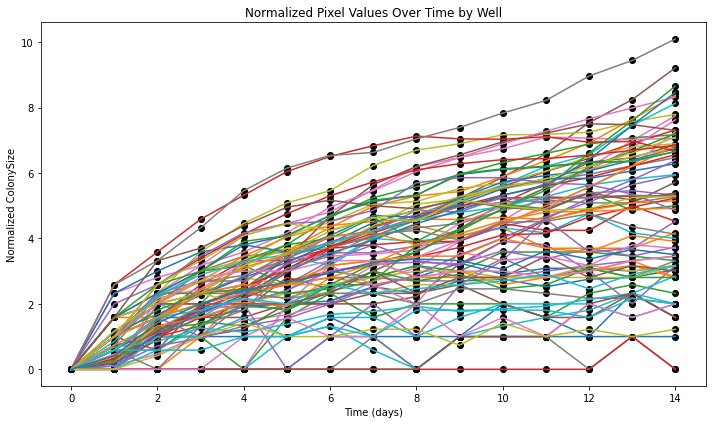

In [324]:
import re

# df = pd.DataFrame(data)
# df = pd.DataFrame(data)

# L = ['C11_0','F9__2','F9__1','H8__1','H7__0']
# for l in L:
#     df = df[df['well_ID'] != l]

# Function to convert time string to total minutes
def convert_time_to_minutes(timestr):
    parts = re.match(r"(\d+)d(\d+)h(\d+)m", timestr)
    days, hours, minutes = map(int, parts.groups())
    return (days * 60*24 + hours * 60 + minutes)/1440 

# Convert 'Time' to total minutes
df['TimeMinutes'] = df['Time'].apply(convert_time_to_minutes)

df = df.sort_values(by=['Name', 'ColonyID', 'TimeMinutes'])

# Normalize Pixels to the first value for each Well
# df['NormalizedPixels'] = df.groupby('Well')['Pixels'].transform(lambda x: x / x.iloc[0])

# Normalize the pixel values to the first timepoint for each 'Name'/'ColonyID'
df['NormalizedColonySize'] = df.groupby('well_ID')['ColonySize'].transform(lambda x: x / x.iloc[0] if x.iloc[0] != 0 else 0)

# df['NormalizedColonySize'][df['NormalizedColonySize'] < 1] = 1

# Identify colonies with any point having less than one cell
colonies_to_remove = df[df['NormalizedColonySize'] < 1]['well_ID'].unique()

# Filter out these colonies from the DataFrame
df = df[~df['well_ID'].isin(colonies_to_remove)]

time_grown = 15
df = df[df['TimeMinutes']<time_grown]

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size as desired

# Group by 'Well' and plot
for label, group in df.groupby('well_ID'):
    
    plt.plot(group['TimeMinutes'], np.log2(group['NormalizedColonySize']), label=label)

    
# Group by 'Well' and plot
for label, group in df.groupby('well_ID'):
    plt.scatter(group['TimeMinutes'], np.log2(group['NormalizedColonySize']), c='black', label=label)

plt.xlabel('Time (days)')
plt.ylabel('Normalized ColonySize')
plt.title('Normalized Pixel Values Over Time by Well')
# plt.legend()
plt.tight_layout()
plt.show()

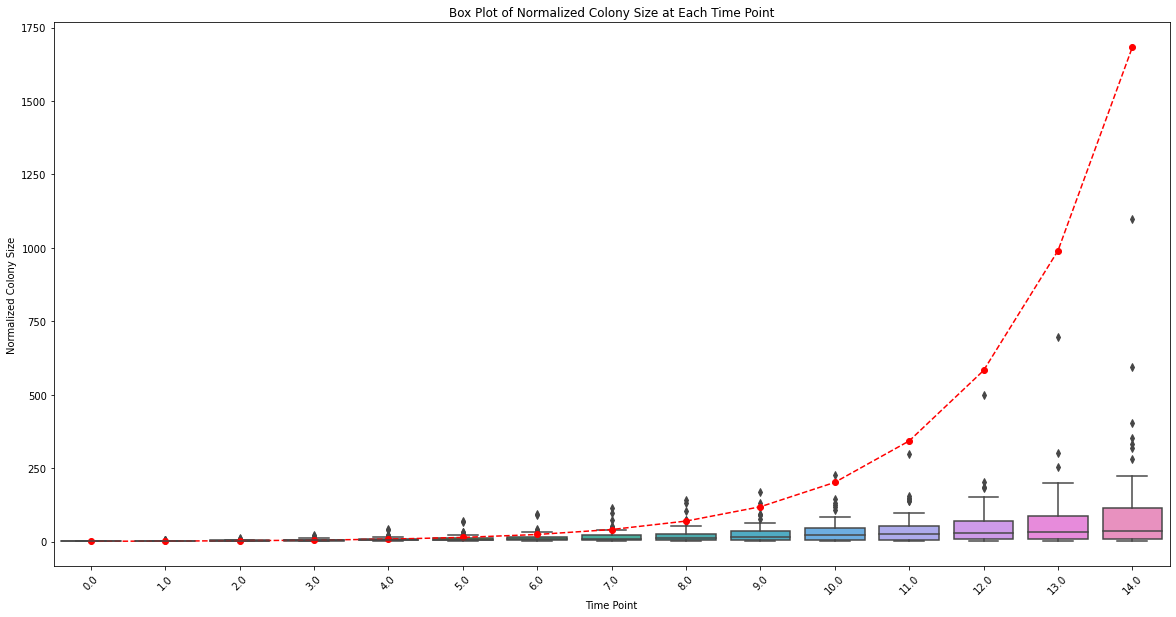

In [325]:
import seaborn as sns
# Set the figure size for readability
plt.figure(figsize=(20, 10))

# Create a boxplot
# Here 'Time' is the column containing the time points,
# 'NormalizedColonySize' is the data to plot,
# and 'Well' is the grouping variable (if you have one)
sns.boxplot(x='TimeMinutes', y='NormalizedColonySize', data=df)

time_points = df['TimeMinutes'].sort_values().unique()
exponential_growth = 1.7**time_points

# Plot the exponential points on top of the boxplot
plt.plot(time_points, exponential_growth, 'ro')  # 'ro' is for red colored dots

# Optional: connect the dots with a line to indicate the trend
plt.plot(time_points, exponential_growth, 'r--')  # 'r--' is for a red dashed line

# Set plot title and labels
plt.title('Box Plot of Normalized Colony Size at Each Time Point')
plt.xlabel('Time Point')
plt.ylabel('Normalized Colony Size')

# Show the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if needed
plt.show()

In [326]:
# Group by 'well_ID', then take the last entry for each group
df_final_timepoint = df[df['TimeMinutes']<time_grown].groupby('well_ID').apply(lambda x: x.iloc[-1])

# Sort the well_IDs by the 'Pixels' column in descending order
top_wells = df_final_timepoint.sort_values('ColonySize', ascending=False).head(6)

# Display the top 5 well_IDs with the largest 'Pixels' values at the final timepoint
print("Top 5 well_IDs with the most pixels at the final time point:")
print(top_wells[['NormalizedColonySize']])

Top 5 well_IDs with the most pixels at the final time point:
         NormalizedColonySize
well_ID                      
A6__0              596.000000
F8__0              353.500000
A8__0              215.384615
F11_0              405.000000
B2__0              332.500000
D3__0              154.375000


In [327]:
#Fit Model

In [328]:
# Add expanding and committed ID
df['ProliferationID'] = [0]*len(df["TimeMinutes"])
for day in np.unique(df["TimeMinutes"]):
    logic_d = df['NormalizedColonySize'] > df[df["TimeMinutes"] == day].quantile(.90)['NormalizedColonySize']
    logic_d[df["TimeMinutes"] != day] = False
    
    HOLD = df['ProliferationID']
    
    HOLD[logic_d] = 1

    df['ProliferationID'] = HOLD

<ipython-input-328-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOLD[logic_d] = 1
<ipython-input-328-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOLD[logic_d] = 1
<ipython-input-328-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOLD[logic_d] = 1
<ipython-input-328-abb226877c81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

Best-fit parameters:
k1: 0.5020142959861582
Growth rate: 0.7402496205544086


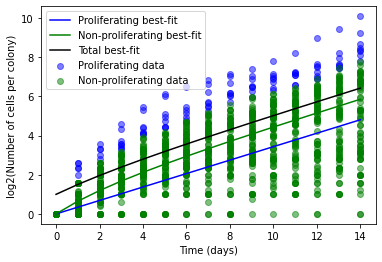

In [329]:
df = df.sort_values(by=["TimeMinutes"])

from scipy.optimize import minimize
from scipy.integrate import odeint
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import minimize


prolif_data = [ i for i in df['NormalizedColonySize'][df['ProliferationID']==1] ] 

non_prolif_data = [ i for i in df['NormalizedColonySize'][df['ProliferationID']==0] ] 

synthetic_data_combined = np.array(df['NormalizedColonySize'])
t_synthetic_repeated = np.array(df["TimeMinutes"])

# Initial conditions
y0 = [1, 1]  # Initial number of proliferating and non-proliferating cells

# Time vector
t = np.linspace(0, 10, 100)  # Time points from 0 to 100 with 100 points


# Define the ODE model
def two_state_system(y, t, k1, growth_rate):
    proliferating, non_proliferating = y
    
    dydt = [
        growth_rate * proliferating - k1 * proliferating ,  # Change in proliferating cells
        k1 * proliferating   # Change in non-proliferating cells
    ]
    return dydt


def cost_function_combined(params, t, combined_data):
    k1, growth_rate = params
    solution = odeint(two_state_system, y0, t, args=(k1, growth_rate))

    # Combine the model's populations into a single population
    combined_solution = np.sum(solution, axis=1)

    # Calculate the sum of squared differences
    ssd = np.sum((combined_solution - combined_data) ** 2)
    return ssd

# Initial conditions
y0 = [1, 1]  # Initial number of proliferating and non-proliferating cells

# Initial parameter values
initial_params = [0.2, 0.7]  # Initial values for k1, and growth_rate


# Optimize the parameters
result = minimize(cost_function_combined, initial_params, args=(t_synthetic_repeated, synthetic_data_combined), method='L-BFGS-B', bounds=[(0, None), (0, None)])

# Extract the best-fit parameters
k1_best, growth_rate_best = result.x


# Generate the best-fit solution
solution_best_fit = odeint(two_state_system, y0, t_synthetic_repeated, args=(k1_best, growth_rate_best))

# # Evaluate the goodness of fit using the R-squared value
# ssd_best_fit = np.sum((solution_best_fit - experimental_data) ** 2)
# sst = np.sum((experimental_data - np.mean(experimental_data, axis=0)) ** 2)
# r_squared = 1 - (ssd_best_fit / sst)

print("Best-fit parameters:")
print("k1:", k1_best)
print("Growth rate:", growth_rate_best)
#print("R-squared:", r_squared)

# Get the time points corresponding to proliferating and non-proliferating data
prolif_time_points = df['TimeMinutes'][df['ProliferationID']==1] 
non_prolif_time_points = df['TimeMinutes'][df['ProliferationID']==0] 


path_to_save = '/Users/raul/Desktop/96well_mask/plate2_mCherry_sup1.pdf'

with PdfPages(path_to_save) as pdf:
    # Set up the figure and axis
    fig, ax = plt.subplots()
    # Plot the experimental data
    ax.scatter(prolif_time_points, np.log2(prolif_data), label='Proliferating data', c='b', marker='o', alpha=0.5)
    ax.scatter(non_prolif_time_points, np.log2(non_prolif_data), label='Non-proliferating data', c='g', marker='o', alpha=0.5)

    # Plot the best-fit model
    ax.plot(t_synthetic_repeated, np.log2(solution_best_fit[:, 0]), label='Proliferating best-fit', c='b', linestyle='-')
    ax.plot(t_synthetic_repeated, np.log2(solution_best_fit[:, 1]), label='Non-proliferating best-fit', c='g', linestyle='-')
    ax.plot(t_synthetic_repeated, np.log2(solution_best_fit[:, 0]+solution_best_fit[:, 1]), label='Total best-fit', c='k', linestyle='-')


    plt.xlabel('Time (days)')
    plt.ylabel('log2(Number of cells per colony)')
    plt.legend()
    plt.show()


    pdf.savefig(fig)



In [330]:
synthetic_data_combined = np.array(df['NormalizedColonySize'])
t_synthetic_repeated = np.array(df["TimeMinutes"])


synthetic_data_combined = np.array([ i for i in df['NormalizedColonySize'][df['ProliferationID']==1] ]) 
t_synthetic_repeated= np.array([ i for i in df['TimeMinutes'][df['ProliferationID']==1] ] )

from scipy.optimize import curve_fit
# Function to calculate the power-law with constants a and b

# f = a * x^b    => $$P_t = P_o * \lambda^t $$

def power_law(x, a, b):
    return a*np.power(b, x)

[5.2, 9.4, 14.0625, 24.5625, 36.875, 51.785714285714285, 64.75, 88.625, 104.0, 127.25, 151.925, 199.94166666666666, 274.009375, 450.90625]
Fit parameters and standard deviations:

    Po = 5.779 - 1.461
lambda = 1.358 - 0.027


Division rate:

    ln(mean(data_lambda)) = 0.509
ln(mean(expo_lambda_exp)) = 1.000

STD
ln(mean(std_data_lambda)) = -2.328


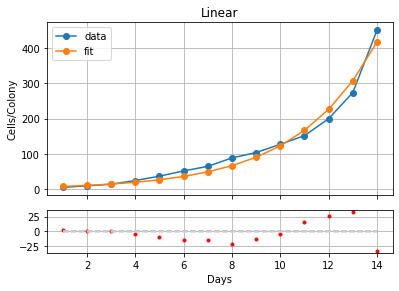

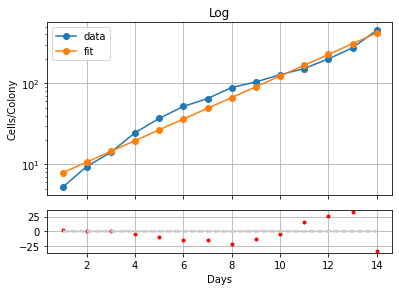

In [331]:

df_expanding = df[df['ProliferationID']==1]

# Data to fit
days = np.unique(df_expanding["TimeMinutes"])
day_col_mean    = [np.mean(df_expanding['NormalizedColonySize'][df_expanding['TimeMinutes'] == i]) for i in np.unique(df_expanding['TimeMinutes'])]


print(day_col_mean )
# Fit data
pars, cov = curve_fit(f=power_law, xdata=days, ydata=day_col_mean, p0=[1, 1.5], bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))


# Calculate the residuals
res = day_col_mean - power_law(days, *pars)

print("Fit parameters and standard deviations:")
print("")
print('    Po = {:0.3f} - {:0.3f}'.format(pars[0], stdevs[0]))
print('lambda = {:0.3f} - {:0.3f}'.format(pars[1], stdevs[1]))
print("")

#Division rates
div_rate = [day_col_mean[i]/day_col_mean[i-1] for i in range(1,len(day_col_mean))]


exp_mod = 2**days
div_rate_exp = [exp_mod[i]/exp_mod[i-1] for i in range(1,len(exp_mod))]

print("")
print("Division rate:")
print("")
print('    ln(mean(data_lambda)) = {:0.3f}' .format(np.log2(np.mean(div_rate))))

print('ln(mean(expo_lambda_exp)) = {:0.3f}' .format(np.log2(np.mean(div_rate_exp))))
print("")
print("STD")
print('ln(mean(std_data_lambda)) = {:0.3f}'.format(np.log2(np.std(div_rate))))


#PLOT
fig1 = plt.figure(1)

#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.plot(days,day_col_mean,'-o')
plt.plot(days,power_law(days, *pars),'-o')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel('Cells/Colony')
plt.title("Linear")
plt.legend(["data","fit"])
plt.grid()

#Residual plot
difference = power_law(days, *pars) - day_col_mean
frame2=fig1.add_axes((.1,.1,.8,.15))        
plt.plot(days,difference,'.r')
plt.plot(days,days*0,'--',color = "gray")
plt.plot(days,days*0 + len(days)*[1],'--',color = "lightgray")
plt.plot(days,days*0 + len(days)*[-1],'--',color = "lightgray")
plt.xlabel('Days')
plt.grid()
# plt.ylim(-2.5,2.5)
plt.savefig('/Users/raul/Desktop/96well_mask/plate2_mCherry_sup2.pdf')

fig2 = plt.figure(2)
#Log
frame1=fig2.add_axes((.1,.3,.8,.6))
plt.plot(days,day_col_mean,'-o')
plt.plot(days,power_law(days, *pars),'-o')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.yscale("log")
plt.ylabel('Cells/Colony')
plt.legend(["data","fit"])
plt.title("Log")
plt.grid()

#Residual plot
difference = power_law(days, *pars) - day_col_mean
frame2=fig2.add_axes((.1,.1,.8,.15))        
plt.plot(days,difference,'.r')
plt.plot(days,days*0,'--',color = "gray")
plt.plot(days,days*0 + len(days)*[1],'--',color = "lightgray")
plt.plot(days,days*0 + len(days)*[-1],'--',color = "lightgray")
plt.xlabel('Days')
# plt.ylim(-2.5,2.5)
plt.grid()

# path_to_save = cwd + 'Paper/outputs/figures/supplement_figure1/supplement_figure1_H1.pdf'
plt.savefig('/Users/raul/Desktop/96well_mask/plate2_mCherry_sup3.pdf')